### This is a notebook explaining the conversion of a pytorch modle to a tflite model without metadata. 
### Please note that this code runs only on kaggle and does not run on google colab. 
### It is hard to make it work using on-device jupyter notebook (would not recommed).

In [5]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F

### This is the implementation of the RepNet model 
https://github.com/ezrealzhang/REPNet_NTIRE23-RTSR

In [6]:
class repnet(nn.Module):
    def __init__(self, upscale = 3):
        super(repnet, self).__init__()

        self.upscale = upscale
        num_feat = 32
        down_scale = 2

        if self.upscale == 2:
            num_repconv = 1
        else:
            num_repconv = 2

        self.downsampler = nn.PixelUnshuffle(down_scale)

        self.body = nn.ModuleList()

        self.body.append(nn.Conv2d(3 * down_scale * down_scale, num_feat, 3, 1, 1)) 

        activation = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.body.append(activation)

        # the body structure
        for _ in range(num_repconv):

            self.body.append(nn.Conv2d(num_feat, num_feat, 3, 1, 1))
            self.body.append(activation)

        # the last conv

        self.body.append(nn.Conv2d(num_feat, 3 * upscale*down_scale * upscale*down_scale, 3, 1, 1))

        # upsample
        self.upsampler = nn.PixelShuffle(upscale*down_scale)

    def forward(self, x):
        out = self.downsampler(x)

        for i in range(0, len(self.body)):
            out = self.body[i](out)

        out = self.upsampler(out)
        base = F.interpolate(x, scale_factor=self.upscale, mode='bilinear')
        out += base
        return out

In [7]:
model = repnet(3)

In [8]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
repnet                                   --
├─PixelUnshuffle: 1-1                    --
├─ModuleList: 1-2                        --
│    └─Conv2d: 2-1                       3,488
│    └─LeakyReLU: 2-2                    --
│    └─Conv2d: 2-3                       9,248
│    └─LeakyReLU: 2-4                    --
│    └─Conv2d: 2-5                       9,248
│    └─LeakyReLU: 2-6                    --
│    └─Conv2d: 2-7                       31,212
├─PixelShuffle: 1-3                      --
Total params: 53,196
Trainable params: 53,196
Non-trainable params: 0

In [9]:
import torch

weights_path = "/kaggle/input/repnet-rtsr/pytorch/default/1/repnet_x3.pth"  
saved_weights = torch.load(weights_path, map_location='cpu', weights_only = True)

model.load_state_dict(saved_weights)

<All keys matched successfully>

In [10]:
model.eval()

repnet(
  (downsampler): PixelUnshuffle(downscale_factor=2)
  (body): ModuleList(
    (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(32, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (upsampler): PixelShuffle(upscale_factor=6)
)

### Test the model once before conversion

torch.Size([275, 220, 3])
pixel_unshuffle expects height to be divisible by downscale_factor, but input.size(-2)=275 is not divisible by 2
torch.Size([230, 219, 3])
pixel_unshuffle expects width to be divisible by downscale_factor, but input.size(-1)=219 is not divisible by 2
torch.Size([758, 596, 3])
0.5502681732177734
torch.Size([286, 304, 3])
0.07823324203491211
torch.Size([148, 201, 3])
pixel_unshuffle expects width to be divisible by downscale_factor, but input.size(-1)=201 is not divisible by 2


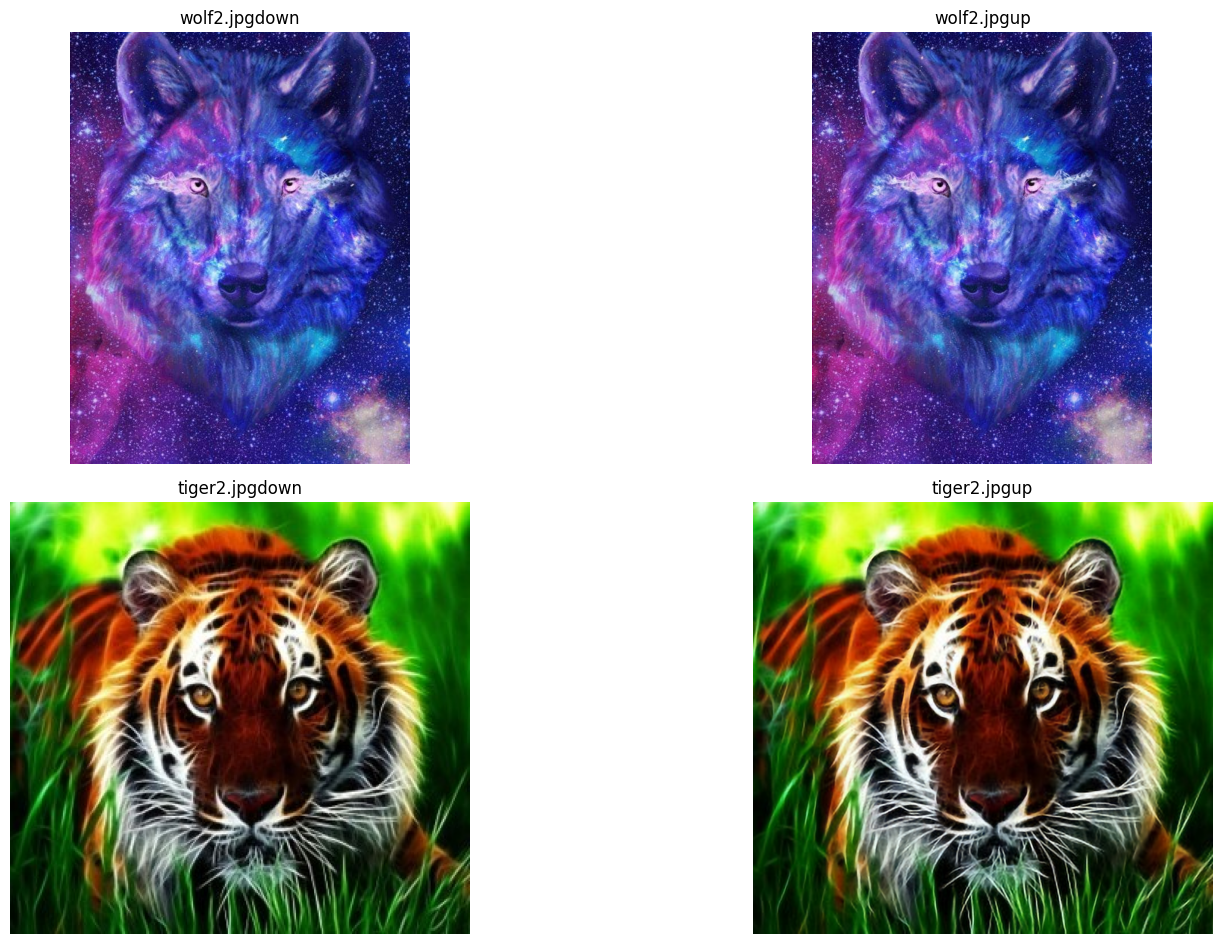

In [11]:
import cv2
import os
import time
import numpy as np
import matplotlib.pyplot as plt


base_dir = '/kaggle/input/film-image/'
i = 0

plt.figure(figsize=(15, 80))  # Set the overall figure size


for img_name in os.listdir(base_dir)[:5]:
    img = cv2.imread(base_dir + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.tensor(img).to('cpu')
    print(img_tensor.shape)

    expanded_tensor = (img_tensor.unsqueeze(0)).permute(0, 3, 1, 2)
    try:
        start = time.time()
        out_tensor = model(expanded_tensor/ 255.0 ).clamp(0, 1)
        end = time.time()
    except RuntimeError as e:
        print(e)
        continue
    print(end - start)

    out_tensor = out_tensor.squeeze()


    image = out_tensor.permute(1, 2, 0) # Shape: [256, 256, 3]
    
    # Step 2: Convert to NumPy
    image = image.detach().numpy()
    
    # Step 3: Scale to [0, 255] and convert to uint8
    image = (image * 255.0).astype(np.uint8)
    # Create subplots
    cv2.imwrite(f"/kaggle/working/{img_name}", image)
    # First subplot
    plt.subplot(17, 2, 2*i+2)  # (rows, cols, index)
    plt.imshow(image)#cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(img_name+"up")
    plt.axis("off")  # Hide axes
    
    # Second subplot
    plt.subplot(17, 2, 2*i+1)
    plt.imshow(img)#cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(img_name+"down")
    plt.axis("off")
    
    plt.tight_layout()  # Adjust spacing
    i += 1



plt.show()  


### Installing the libraries required to convert to tflite
We have to downgrade somoe libraries and install some other

In [12]:
!pip install tensorflow==2.13.1
!pip install tflite-support==0.4.2
!pip install torch torchvision ai-edge-torch

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sqlalchemy 2.0.36 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
albucore 0.0.19 requires nump

Ignore all the errors above. 
Our code still works without solving them

### Converting the model

Inference output shape: (1, 3, 2160, 3840)
Exported TFLite model to /kaggle/working/repnet.tflite


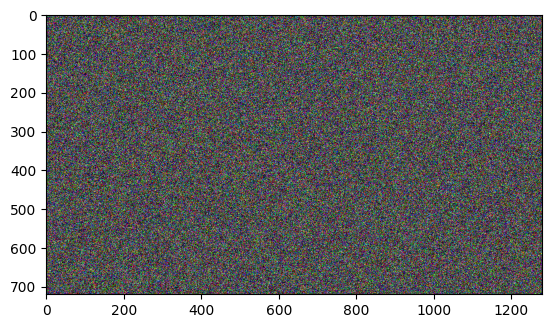

In [13]:
import torch
import torchvision
import ai_edge_torch
import matplotlib.pyplot as plt

sample_input = (torch.randn(1, 3, 720, 1280),)


image = sample_input[0].squeeze(0).permute(1, 2, 0).numpy()
# Display the image
plt.imshow(image)

# Convert the PyTorch model to an on-device model using AI Edge Torch
edge_model = ai_edge_torch.convert(model, sample_input)

# Run a quick inference check
output = edge_model(*sample_input)
print("Inference output shape:", output.shape)

# Export the TFLite model to a file
tflite_model_path = "/kaggle/working/repnet.tflite"
edge_model.export(tflite_model_path)
print("Exported TFLite model to", tflite_model_path)

### Test the interpreter in Python once before using it in Kotlin / Android Studios

In [14]:
import tensorflow as tf 



# Load the TFLite model

interpreter = tf.lite.Interpreter(model_path="/kaggle/working/repnet.tflite") 



# Get input and output details

input_details = interpreter.get_input_details()

output_details = interpreter.get_output_details()



# Print information

print("Input details:")
print(input_details)


print("\nOutput details:")
print(output_details)


Input details:
[{'name': 'serving_default_args_0:0', 'index': 0, 'shape': array([   1,    3,  720, 1280], dtype=int32), 'shape_signature': array([   1,    3,  720, 1280], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

Output details:
[{'name': 'StatefulPartitionedCall:0', 'index': 36, 'shape': array([   1,    3, 2160, 3840], dtype=int32), 'shape_signature': array([   1,    3, 2160, 3840], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [15]:
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/repnet.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess an image
image_path = "/kaggle/input/film-image/panda2.jpg"  
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
image = cv2.resize(image, (input_details[0]['shape'][3], input_details[0]['shape'][2]))
print(image.shape)
image = np.expand_dims(image, axis=0).astype(np.float32) 
image = np.transpose(image, (0, 3, 1, 2))
print(image.shape)

(1500, 1500, 3)
(720, 1280, 3)
(1, 3, 720, 1280)


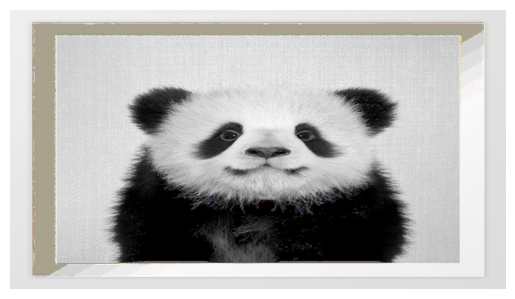

In [16]:
# Set the tensor
interpreter.set_tensor(input_details[0]['index'], image)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Post-process and display output
output_image = np.squeeze(output_data).astype(np.uint8)
output_image = np.transpose(output_image, (1, 2, 0))
# Display with Matplotlib (since OpenCV windows don't work in Kaggle)
plt.imshow(output_image)
plt.axis("off")
plt.show()

### Download the tflite model from kaggle/working